In [39]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology

In [40]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")
df_h = df[df['mhc']=='HLA-A-0201'][['sequence','meas']]
df_h['log_meas']=1-np.log(df_h['meas'])/math.log(50000)
max_len=df_h['sequence'].str.len().max()
n_peptides = df_h['sequence'].count()
from mhcflurry.amino_acid import common_amino_acids
def amino_acid_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df_h['encoded_peptides'] = df_h.sequence.apply(lambda seq: amino_acid_encoding(seq, max_len))
df_h['peptide_length'] = df_h['sequence'].str.len()
df_all = df_h.reindex(np.random.permutation(df_h.index))
df_all.head(10)

,sequence,meas,log_meas,encoded_peptides,peptide_length
14308,ALTGTEKL,50000.000000,0.000000,"[1, 10, 17, 6, 17, 4, 9, 10, 0, 0, 0, 0, 0, 0, 0]",8
14467,ADAKAAAAV,10000.000000,0.148750,"[1, 3, 1, 9, 1, 1, 1, 1, 18, 0, 0, 0, 0, 0, 0]",9
15757,FLDPATTTS,1781.000000,0.308218,"[5, 10, 3, 13, 1, 17, 17, 17, 16, 0, 0, 0, 0, ...",9
20164,TKDAERGKL,20000.000000,0.084687,"[17, 9, 3, 1, 4, 15, 6, 9, 10, 0, 0, 0, 0, 0, 0]",9
13644,SLVDKEDTDI,17194.419459,0.098656,"[16, 10, 18, 3, 9, 4, 3, 17, 3, 8, 0, 0, 0, 0, 0]",10
21052,YLEPGPVTV,46.000000,0.646144,"[20, 10, 4, 13, 6, 13, 18, 17, 18, 0, 0, 0, 0,...",9
20530,VLFTVLAIV,7.627695,0.812216,"[18, 10, 5, 17, 18, 10, 1, 8, 18, 0, 0, 0, 0, ...",9
17111,ITDVQDMDP,20000.000000,0.084687,"[8, 17, 3, 18, 14, 3, 11, 3, 13, 0, 0, 0, 0, 0...",9
18396,MMLAQAYYG,273.000000,0.481554,"[11, 11, 10, 1, 14, 1, 20, 20, 6, 0, 0, 0, 0, ...",9
14514,AHSTIMPRL,20000.000000,0.084687,"[1, 7, 16, 17, 8, 11, 13, 15, 10, 0, 0, 0, 0, ...",9


In [41]:
def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

In [42]:
def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000) 

In [43]:
df_all['affinity_label'] = affinity_label(df_all['log_meas'])
df_all.head(10)

,sequence,meas,log_meas,encoded_peptides,peptide_length,affinity_label
14308,ALTGTEKL,50000.000000,0.000000,"[1, 10, 17, 6, 17, 4, 9, 10, 0, 0, 0, 0, 0, 0, 0]",8,0
14467,ADAKAAAAV,10000.000000,0.148750,"[1, 3, 1, 9, 1, 1, 1, 1, 18, 0, 0, 0, 0, 0, 0]",9,1
15757,FLDPATTTS,1781.000000,0.308218,"[5, 10, 3, 13, 1, 17, 17, 17, 16, 0, 0, 0, 0, ...",9,2
20164,TKDAERGKL,20000.000000,0.084687,"[17, 9, 3, 1, 4, 15, 6, 9, 10, 0, 0, 0, 0, 0, 0]",9,1
13644,SLVDKEDTDI,17194.419459,0.098656,"[16, 10, 18, 3, 9, 4, 3, 17, 3, 8, 0, 0, 0, 0, 0]",10,1
21052,YLEPGPVTV,46.000000,0.646144,"[20, 10, 4, 13, 6, 13, 18, 17, 18, 0, 0, 0, 0,...",9,4
20530,VLFTVLAIV,7.627695,0.812216,"[18, 10, 5, 17, 18, 10, 1, 8, 18, 0, 0, 0, 0, ...",9,4
17111,ITDVQDMDP,20000.000000,0.084687,"[8, 17, 3, 18, 14, 3, 11, 3, 13, 0, 0, 0, 0, 0...",9,1
18396,MMLAQAYYG,273.000000,0.481554,"[11, 11, 10, 1, 14, 1, 20, 20, 6, 0, 0, 0, 0, ...",9,3
14514,AHSTIMPRL,20000.000000,0.084687,"[1, 7, 16, 17, 8, 11, 13, 15, 10, 0, 0, 0, 0, ...",9,1


## Distribution of affinity labels along all peptides

In [44]:
data = []
for i in [0,1,2,3,4]:
    data.append(df_all[df_all['affinity_label'] == i].affinity_label.count())
data, np.asarray(data).sum()

([1380, 3530, 1505, 1439, 1711], 9565)

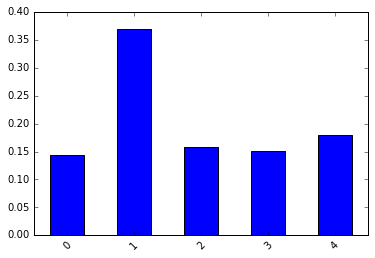

In [45]:
pd.Series(data/np.asarray(data).sum()).plot(kind='bar', rot= 45)

In [46]:
data_8 = []
data_9 = []
data_10 = []
data_11 = []
for i in [0,1,2,3,4]:
    data_8.append(df_all[df_all['affinity_label']==i][df_all['peptide_length'] <=8].affinity_label.count())
for i in [0,1,2,3,4]:
    data_9.append(df_all[df_all['affinity_label']==i][df_all['peptide_length'] ==9].affinity_label.count())
for i in [0,1,2,3,4]:
    data_10.append(df_all[df_all['affinity_label']==i][df_all['peptide_length'] ==10].affinity_label.count())
for i in [0,1,2,3,4]:
    data_11.append(df_all[df_all['affinity_label']==i][df_all['peptide_length'] >=11].affinity_label.count())

/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/giancarlokerg/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [47]:
matrix = pd.DataFrame({'A': data_8/np.asarray(data_8).sum(), 'B': data_9/np.asarray(data_9).sum(), 'C': data_10/np.asarray(data_10).sum(), 'D': data_11/np.asarray(data_11).sum()}, index = [0,1,2,3,4])
matrix

,A,B,C,D
0,0.416,0.141503,0.129457,0.308943
1,0.336,0.410430,0.252547,0.292683
2,0.176,0.132021,0.230475,0.170732
3,0.048,0.132309,0.211375,0.113821
4,0.024,0.183738,0.176146,0.113821


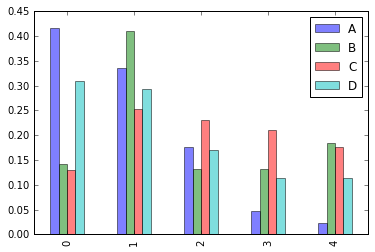

In [33]:
matrix.plot(kind='bar', alpha=0.5)

A $\leq 8$ mer, B = 9 mer, C = 10 mer, D $\geq 11$ mer

## Clustering strong binders 

In [ ]:
df_all[df_all['affinity_label']==4]['encoded_peptides']

In [61]:
df_all[df_all['affinity_label']==4]['encoded_peptides'].index

Int64Index([21052, 20530, 13838, 17785, 14293, 13151, 17819, 17437, 13057,
            17821,
            ...
            14704, 17960, 17650, 12617, 14898, 13809, 16889, 12323, 14915,
            15930],
           dtype='int64', length=1711)

In [63]:
df_all[df_all['affinity_label']==4]['encoded_peptides'].iloc[0]

array([20, 10,  4, 13,  6, 13, 18, 17, 18,  0,  0,  0,  0,  0,  0])

In [97]:
def amino_acid_count(X,i):
    result = np.empty(21) 
    for j in range(len(X)):
        result[X.iloc[j][i]] = result[X.iloc[j][i]] + 1
    return np.array(result, dtype=int) 


In [154]:
def amino_acid_distribution_per_position_plot(X,i,c):
    return pd.Series(amino_acid_count(X,i)/amino_acid_count(X,i).sum()).plot(kind='bar',alpha=0.5, color= c)

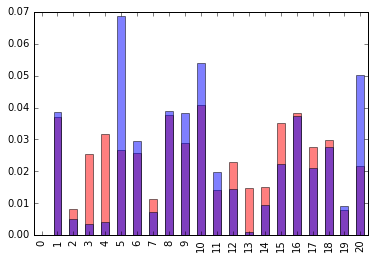

In [182]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],0,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],0,'b')

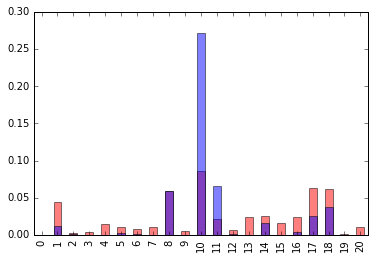

In [183]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],1,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],1,'b')

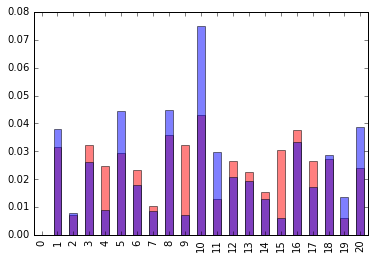

In [184]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],2,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],2,'b')

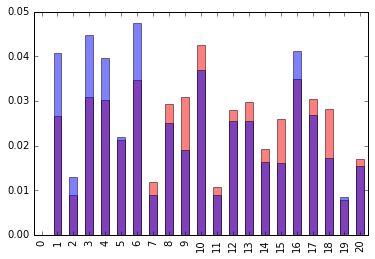

In [185]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],3,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],3,'b')

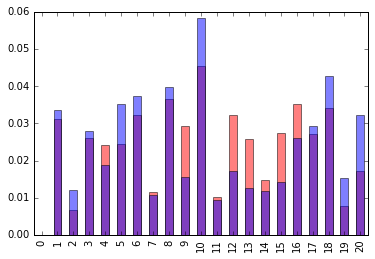

In [186]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],4,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],4,'b')

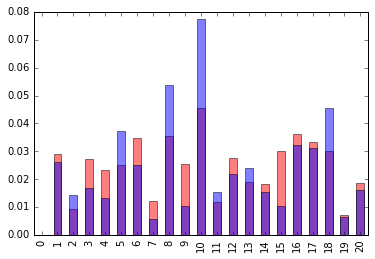

In [187]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],5,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],5,'b')

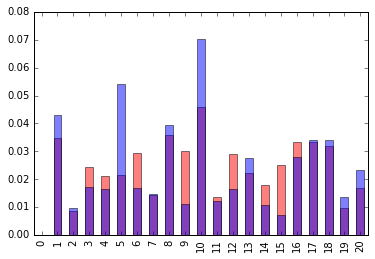

In [188]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],6,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],6,'b')

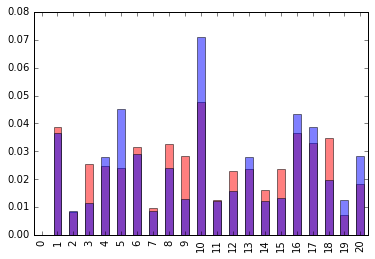

In [189]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],7,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],7,'b')

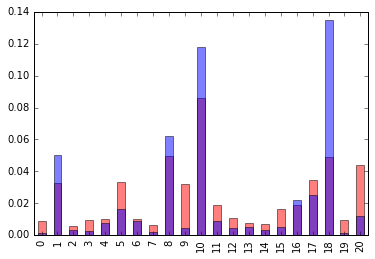

In [190]:
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']< 3]['encoded_peptides'],8,'r')
amino_acid_distribution_per_position_plot(df_all[df_all['affinity_label']>= 3]['encoded_peptides'],8,'b')